In [2]:
from processor.processor import Processor as processor
from database.adatabase import ADatabase
from xgboost import XGBRegressor
from statistics import mean
import math
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tqdm import tqdm
from dotenv import load_dotenv
from asset.stock import Stock
from asset.bond import Bond
from asset.option import Option
import warnings
import pytz
import copy
warnings.simplefilter(action="ignore")
import pickle
import wrds

In [3]:
market = ADatabase("market")
sec = ADatabase("sec")
market = ADatabase("market")
fred = ADatabase("fred")
db = ADatabase("sapling")

In [4]:
# market.connect()
# sp500 = market.retrieve("stock_names")
# market.disconnect()
sp500 = sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies",attrs={"id":"constituents"})[0].rename(columns={"Symbol":"ticker"})

In [5]:
fred.connect()
market_yield = fred.retrieve("market_yield")
market_yield = market_yield.rename(columns={"value":"rf"})
market_yield["rf"] = market_yield["rf"].replace(".",np.nan)
market_yield.dropna(inplace=True)
market_yield["rf"] = [float(x)/100 for x in market_yield["rf"]]
market_yield = processor.column_date_processing(market_yield)
spy = fred.retrieve("sp500")
spy = spy.rename(columns={"value":"spy"})
spy["spy"] = spy["spy"].replace(".",np.nan)
spy.dropna(inplace=True)
spy["spy"] = [float(x) for x in spy["spy"]]
spy = processor.column_date_processing(spy)
spy = spy.sort_values("date")
fred.disconnect()

In [6]:
unneeded_columns = ["ticker","year","quarter","gsector","gicdesc","y"]

In [7]:
sp500

,ticker,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,XYL,Xylem Inc.,Industrials,Industrial Machinery & Supplies & Components,"White Plains, New York",2011-11-01,1524472,2011
499,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
500,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
501,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927


In [268]:
market.connect()
sec.connect()
factors_df = []
for ticker in tqdm(sp500["ticker"].unique()):
    try:
        price = processor.column_date_processing(market.query("prices",{"ticker":ticker}))
        price["year"] = [x.year for x in price["date"]]
        price["quarter"] = [x.quarter for x in price["date"]]
        filings = processor.column_date_processing(sec.query("financials",{"ticker":ticker})).drop(["gsector","gicdesc"],axis=1)
        filings["year"] = [x.year for x in filings["date"]]
        filings["quarter"] = [x.quarter for x in filings["date"]]
        filings["quarter"] = filings["quarter"].shift(1)
        price = price.drop(["date","ticker"],axis=1).merge(filings.drop(["date","ticker"],axis=1),on=["year","quarter"],how="left").groupby(["year","quarter"]).mean().reset_index()
        price["ticker"] = ticker
        price["y"] = price["adjclose"].shift(-4)
        factors_df.append(price)
    except Exception as e:
        # print(ticker,str(e))
        continue
sec.disconnect()
market.disconnect()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 503/503 [01:01<00:00,  8.13it/s]


In [269]:
factors_df = pd.concat(factors_df)

In [270]:
for column in factors_df:
    if column in factors_df[column]:
        factors_df.drop(column,axis=1,inplace=True)

In [271]:
factors_df = factors_df.fillna(0)

In [272]:
start_year = 2008
end_year = 2015
sim_end_year = 2022

In [273]:
model = XGBRegressor()
factors = ["ptb","roa","mktcap","bm","short_debt","divyield","adjclose"]
factors_df.sort_values(["year","quarter"],inplace=True)
training_data = factors_df[(factors_df["year"]>start_year) & (factors_df["year"]<end_year)].dropna()
sim = factors_df[(factors_df["year"]>=end_year-1) & (factors_df["year"]<sim_end_year)].drop("y",axis=1).dropna()
model.fit(training_data[factors],training_data["y"])
sim["prediction"] = model.predict(sim[factors])

In [274]:
prices = []
market.connect()
db.cloud_connect()
for ticker in tqdm(sp500["ticker"].unique()):
    try:
        price = processor.column_date_processing(market.query("historical_prices",{"ticker":ticker}))
        price["year"] = [x.year for x in price["date"]]
        price["quarter"] = [x.quarter for x in price["date"]]
        price.sort_values("date",inplace=True)
        price = price.merge(sp500[["ticker","GICS Sector"]],on="ticker",how="left")
        price = price.merge(sim[["year","quarter","ticker","prediction"]],on=["year","quarter","ticker"],how="left")
        price = price.merge(spy[["date","spy"]],on="date",how="left")
        price = price.merge(market_yield[["date","rf"]],on="date",how="left")
        price["expected_return"] = (price["prediction"] - price["adjclose"]) / price["adjclose"]
        price["historical_return"] = price["adjclose"].pct_change(90)
        price["factor_return"] = price["spy"].pct_change(90)
        price["cov"] = price["factor_return"].rolling(100).cov(price["expected_return"])
        price["var"] = price["factor_return"].rolling(100).var()
        price["beta"] = price["cov"] / price["var"]
        price["excess_return"] = price["rf"] + price["beta"] * (price["expected_return"] - price["rf"])
        price["sigma"] = price["adjclose"].rolling(262).std()
        prices.append(price)
    except Exception as e:
        print(ticker,str(e))
        continue
market.disconnect()
db.disconnect()

 13%|█████████████████████████████▌                                                                                                                                                                                                          | 64/503 [00:04<00:25, 17.31it/s]

BRK.B 'date'


 15%|███████████████████████████████████▌                                                                                                                                                                                                    | 77/503 [00:05<00:25, 16.51it/s]

BF.B 'date'


 26%|███████████████████████████████████████████████████████████▋                                                                                                                                                                           | 130/503 [00:09<00:25, 14.86it/s]

CPAY 'date'


 42%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                       | 209/503 [00:14<00:20, 14.40it/s]

GEV 'date'


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 424/503 [00:30<00:05, 15.58it/s]

SOLV 'date'


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 494/503 [00:35<00:00, 16.23it/s]

WELL 'date'


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 503/503 [00:35<00:00, 14.04it/s]


In [275]:
sim = pd.concat(prices).dropna()
sim = sim[(sim["date"]<datetime(sim_end_year,1,1)) & (sim["date"]>datetime(end_year,7,1))].groupby(["date","GICS Sector","ticker"]).mean().reset_index()

In [276]:
sim.sort_values("date")

,date,GICS Sector,ticker,adjclose,volume,year,quarter,prediction,spy,rf,expected_return,historical_return,factor_return,cov,var,beta,excess_return,sigma
0,2015-07-02,Communication Services,CHTR,171.800,230057551.8,2015.0,3.0,211.315918,2076.78,0.0240,0.230011,-0.033583,-0.018294,0.000498,0.001131,0.440561,0.114761,12.808760
293,2015-07-02,Industrials,UAL,51.500,273922062.5,2015.0,3.0,55.665779,2076.78,0.0240,0.080889,-0.273522,-0.018294,0.001681,0.001131,1.485537,0.108511,9.080421
292,2015-07-02,Industrials,TXT,44.490,38960337.9,2015.0,3.0,46.677921,2076.78,0.0240,0.049178,-0.018531,-0.018294,0.000144,0.001131,0.127025,0.027198,3.547398
291,2015-07-02,Industrials,TT,39.590,27955554.1,2015.0,3.0,56.058640,2076.78,0.0240,1.817015,2.379424,-0.014272,0.000844,0.000210,4.002048,3.904224,28.456993
290,2015-07-02,Industrials,TDG,227.780,36814942.5,2015.0,3.0,193.897568,2076.78,0.0240,-0.148751,0.011142,-0.018294,0.000205,0.001131,0.180902,-0.007251,19.887359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729468,2021-12-31,Financials,DFS,115.560,88448468.4,2021.0,4.0,110.200821,4766.18,0.0152,-0.046376,-0.106334,0.062402,-0.000108,0.000372,-0.290229,0.033071,13.620721
729467,2021-12-31,Financials,COF,145.090,196782375.0,2021.0,4.0,205.424164,4766.18,0.0152,0.415840,-0.146780,0.062402,-0.000675,0.000372,-1.812133,-0.710812,21.445826
729466,2021-12-31,Financials,CME,118.485,68117631.0,2021.0,4.0,247.859009,4766.18,0.0152,14.105265,9.066217,0.047125,0.017409,0.000336,51.824681,794.545571,100.164842
729478,2021-12-31,Financials,ICE,136.770,117192879.0,2021.0,4.0,140.030548,4766.18,0.0152,0.023840,0.164991,0.062402,-0.000612,0.000372,-1.643109,0.001004,8.123994


In [277]:
# Initialize variables
structure = {"stock":0.5,"bond":0.4,"option":0.1}
start = sim["date"].min() + timedelta(days=1)
end = sim["date"].max()
sectors = list(sim["GICS Sector"].unique())
date = start
number_of_stocks = 1
portfolio = {
    "date": date,
    "tax": 0,
    "fees": 0,
    "cash": 100000,
    "positions": [
        {
            
            "stocks": [{"ticker": "", "adjclose": 0, "quantity": 0} for _ in range(number_of_stocks)],
            "bonds": [{"ticker": "", "adjclose": 0, "quantity": 0} for _ in range(number_of_stocks)],
            "options": [{"ticker": "", "adjclose": 0, "quantity": 0} for _ in range(number_of_stocks)]
        }
        for _ in sectors
    ]
}
states = []
trades = []
annual_balance = 100000
prev_quarter = 0
quarter = 1
for date in sim.sort_values("date")["date"].unique():
    today = sim[sim["date"] == date].copy()
    if today.index.size > 0:
        try:
            portfolio = copy.deepcopy(portfolio)
            cash = portfolio["cash"]
            portfolio["date"] = date
            positions = copy.deepcopy(portfolio["positions"])
            if 1 == math.prod([ticker != "" for ticker in portfolio_tickers]):
                portfolio_tickers = [position["stocks"][0]["ticker"] for position in positions]
                if 1 == math.prod([ticker in today["ticker"].unique() for ticker in portfolio_tickers]):
                    for i in range(11):
                        position = positions[i]
                        stocks = copy.deepcopy(position["stocks"])
                        options = copy.deepcopy(position["options"])
                        bonds = copy.deepcopy(position["bonds"])
                        for j in range(number_of_stocks):
                            stock = stocks[j]
                            bond = bonds[j]
                            option = options[j]
                            ticker = stock["ticker"]
                            row = today[today["ticker"] == ticker].iloc[0]
                            position["stocks"][j] = Stock.update(row, stock)
                            position["bonds"][j] = Bond.update(row, bond)
                            position["options"][j] = Option.update(row, option)
                        positions[i] = position
                    portfolio["positions"] = positions
                    cash = portfolio["cash"]
                    positions = copy.deepcopy(portfolio["positions"])
                    for i in range(11):
                        sector = sectors[i]
                        position = positions[i]
                        stocks = copy.deepcopy(position["stocks"])
                        options = copy.deepcopy(position["options"])
                        bonds = copy.deepcopy(position["bonds"])
                        for j in range(number_of_stocks):
                            stock = stocks[j]
                            bond = bonds[j]
                            option = options[j]
                            ticker = stock["ticker"]
                            notional = (stock["pv"] + option["pv"] + bond["pv"])
                            hpr = int((date - stock["buy_date"]).days)
                            opportunity_row = today[today["GICS Sector"]==sector].sort_values("expected_return", ascending=False).iloc[j]
                            opportunity_ticker = opportunity_row["ticker"]
                            if (hpr > 90):
                                row = today[today["ticker"] == ticker].iloc[0]
                                stock = Stock.sell(row, stock)
                                position["stocks"][j] = stock
                                trades.append(stock)
                                stock = Stock.buy(opportunity_row, stock, notional * structure["stock"])
                                position["stocks"][j] = stock
                                option = Option.sell(row, option)
                                position["options"][j] = option
                                trades.append(option)
                                option = Option.buy(opportunity_row, option, notional * structure["option"])
                                position["options"][j] = option
                                bond = Bond.sell(row, bond)
                                position["bonds"][j] = bond
                                trades.append(bond)
                                bond = Bond.buy(opportunity_row, bond, notional * structure["bond"])
                                position["bonds"][j] = bond
                                positions[i] = position
                        portfolio["positions"] = positions
            portfolio_tickers = [position["stocks"][0]["ticker"] for position in positions]
            if 1 == math.prod([ticker == "" for ticker in portfolio_tickers]):
                for i in range(11):
                    notional = float(cash / 11 / number_of_stocks)
                    position = positions[i]
                    stocks = copy.deepcopy(position["stocks"])
                    sector = sectors[i]
                    for j in range(number_of_stocks):
                        stock = stocks[j]
                        opportunity_row = today[today["GICS Sector"]==sector].sort_values("expected_return", ascending=False).iloc[j]
                        stock = Stock.buy(opportunity_row, stock, notional * structure["stock"])
                        position["stocks"][j] = stock
                        option = Option.buy(opportunity_row, option, notional * structure["option"])
                        position["options"][j] = option
                        bond = Bond.buy(opportunity_row, bond, notional * structure["bond"])
                        position["bonds"][j] = bond
                    positions[i] = position
                portfolio["positions"] = positions
                portfolio["cash"] = 0
            states.append(copy.deepcopy(portfolio))
        except Exception as e:
            print(f"Error on date {date}: {str(e)}")
            continue

In [278]:
portfolios = []
for state in states:
    for i in range(10):
        for j in range(number_of_stocks):
            for asset_class in ["stocks","bonds","options"]:
                view = state["positions"][i][asset_class][j]
                view["date"] = state["date"]
                view["asset_class"] = asset_class
            portfolios.append(state["positions"][i]["stocks"][j])
            portfolios.append(state["positions"][i]["options"][j])
            portfolios.append(state["positions"][i]["bonds"][j])

In [279]:
performance = pd.DataFrame(portfolios).pivot_table(index="date",columns="asset_class",values="pv").reset_index().sort_values("date")
performance = performance.groupby("date").agg({"stocks":"sum","bonds":"sum","options":"sum"}).reset_index()

In [280]:
performance

asset_class,date,stocks,bonds,options
0,2015-07-02,4545.454545,3636.363636,909.090909
1,2015-07-06,4545.454545,3636.363636,909.090909
2,2015-07-07,4549.073782,3636.363636,976.529043
3,2015-07-08,4486.923437,3636.363636,982.926502
4,2015-07-09,4525.714118,3636.363636,978.775252
...,...,...,...,...
1620,2021-12-27,20813.875552,16498.721331,4377.748635
1621,2021-12-28,20671.503678,16498.721331,4390.156259
1622,2021-12-29,20720.900813,16498.721331,4385.857491
1623,2021-12-30,20715.121942,16498.721331,4386.367367


In [281]:
# plt.figure(figsize=(10, 6))  
# for sector in performance["sector"].unique():
#     sector_perf = performance[performance["sector"]==sector]
#     plt.plot(sector_perf["date"].values,sector_perf["stocks"].values)
#     # plt.legend(performance["sector"].unique())
# plt.show()

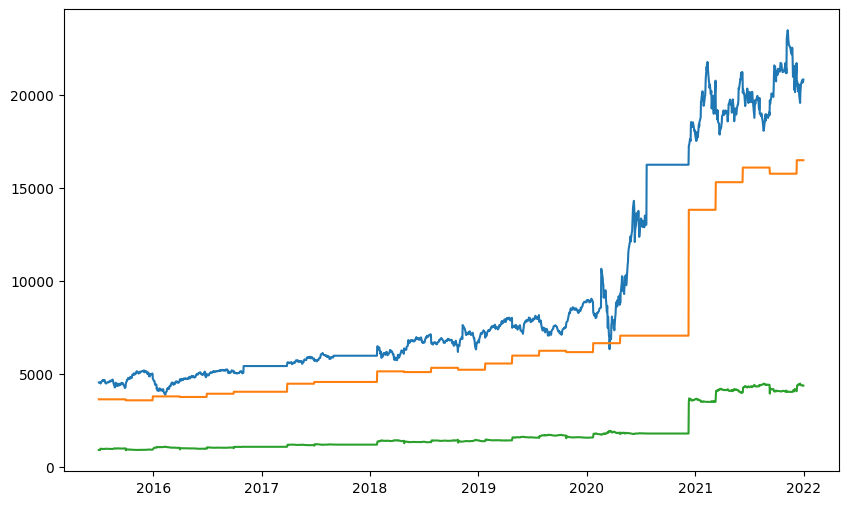

In [282]:
performance = performance.groupby(["date"]).agg({"stocks":"sum","bonds":"sum","options":"sum"}).reset_index()
plt.figure(figsize=(10, 6)) 
plt.plot(performance["date"].values,performance["stocks"].values)
plt.plot(performance["date"].values,performance["bonds"].values)
plt.plot(performance["date"].values,performance["options"].values)
plt.show()

In [283]:
visualization = performance.merge(spy,on="date",how="left")
visualization = visualization.merge(market_yield[["date","rf"]],on="date",how="left")

In [284]:
visualization["pv"] = visualization["stocks"] + visualization["bonds"] + visualization["options"]
visualization["return"] = (visualization["pv"] - visualization["pv"].iloc[0]) / visualization["pv"].iloc[0]
visualization["benchmark_return"] = (visualization["spy"] - visualization["spy"].iloc[0]) / visualization["spy"].iloc[0]
visualization["ir_return"] = (visualization["rf"] - visualization["rf"].iloc[0]) / visualization["rf"].iloc[0]

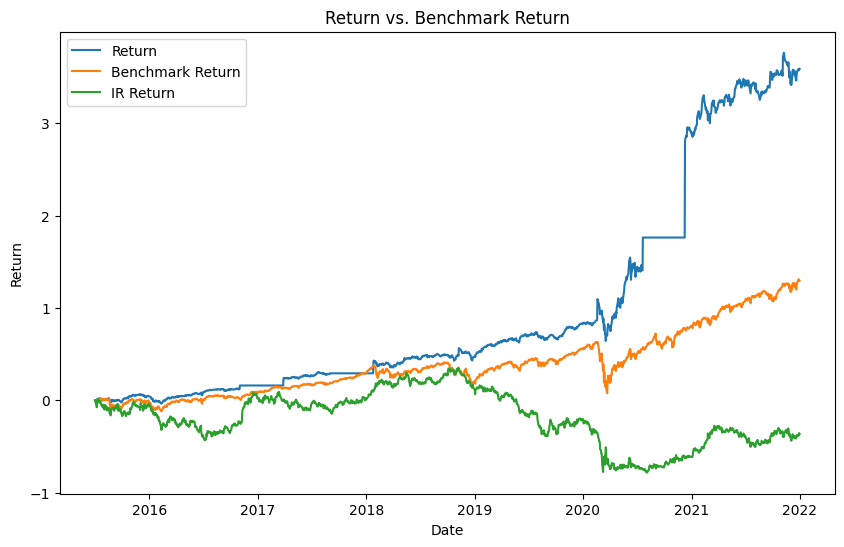

In [285]:
# Set the figure size
plt.figure(figsize=(10, 6))  # Adjust the width and height as needed

# Plot the data
plt.plot(visualization["date"].values, visualization["return"], label="Return")
plt.plot(visualization["date"].values, visualization["benchmark_return"], label="Benchmark Return")
plt.plot(visualization["date"].values, visualization["ir_return"], label="IR Return")

# Add labels and legend
plt.xlabel("Date")
plt.ylabel("Return")
plt.title("Return vs. Benchmark Return")
plt.legend()

# Show the plot
plt.show()


In [286]:
(visualization["return"].iloc[-1] - visualization["benchmark_return"].iloc[-1]) / visualization["return"].std()

2.027483863064154